
1. **SARIMA and SARIMAX Analysis**:
   - Data visualization (plotting the time series).
   - Stationarity check and making the series stationary if needed.
   - ACF and PACF plots to determine AR and MA terms.
   - SARIMA model training and prediction.
   - SARIMAX model if exogenous variables are needed.
   


2. **Facebook Prophet**:
   - Preparing the data for Prophet (renaming columns).
   - Model fitting and forecasting.
   - Visualizing the predictions.
   


3. **Recurrent Neural Networks (RNNs)**:
   - Data preprocessing for RNNs.
   - Building and training the RNN model.
   - Predictions and evaluation.
   
Let's start with the first part: SARIMA and SARIMAX analysis.



# Time Series Analysis with SARIMA, SARIMAX, Facebook Prophet, and RNNs



In this notebook, we'll walk through different methods of time series analysis and forecasting using the provided dataset.

## Table of Contents:
1. [SARIMA and SARIMAX Analysis](#SARIMA-and-SARIMAX-Analysis)
2. [Facebook Prophet Analysis](#Facebook-Prophet-Analysis)
3. [Recurrent Neural Networks (RNNs)](#Recurrent-Neural-Networks)

---



### SARIMA and SARIMAX Analysis



#### Visualizing the Data

First, let's visualize the time series data to understand its patterns and trends.


In [25]:
from capstone_functions import *
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Load the dataset
master_df = pd.read_parquet("../Data/master_df.parquet")

# Set the random.seed(42)
np.random.seed(42)

# sns.set_style('538')
master_df.info()
master_df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1142 entries, 2020-02-15 to 2023-04-01
Data columns (total 59 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   cancel_events                         1142 non-null   Float64
 1   gatherings_restrictions               1142 non-null   Float64
 2   infected                              1142 non-null   Int64  
 3   information_campaigns                 1142 non-null   Float64
 4   internal_movement_restrictions        1142 non-null   Float64
 5   international_movement_restrictions   1142 non-null   Float64
 6   school_closing                        1142 non-null   Float64
 7   stay_home_restrictions                1142 non-null   Float64
 8   stringency_index                      1142 non-null   Float64
 9   susceptible                           1142 non-null   Float64
 10  testing_policy                        1142 non-null   Float64
 11 

,cancel_events,gatherings_restrictions,infected,information_campaigns,internal_movement_restrictions,international_movement_restrictions,school_closing,stay_home_restrictions,stringency_index,susceptible,testing_policy,transport_closing,workplace_closing,confirmed,fatal,recovered,derived_reproduction_rate,kap_mortality_rate,rho_transmission_rate,sig_recovery_rate,t/k_mortality_period,t/r_infection_period,t/s_recovery_period,total_tests,new_tests,...,excess_mortality,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential,facial_coverings,vaccination_policy,average_temperature_celsius,minimum_temperature_celsius,maximum_temperature_celsius,rainfall_mm,snowfall_mm,dew_point,relative_humidity,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_confirmed,new_fatal,new_recovered,new_susceptible,total_removed
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-15,0.0,0.0,15,0.0,0.0,3.0,0.0,0.0,8.33,326687486.0,1.0,0.0,0.0,15,0,0,36.115533,0.000153,0.008665,0.000087,272.977608,4.808697,477.37534,139.5,139.5,...,-2.363827,6.0,2.0,15.0,3.0,2.0,-1.0,0.0,0.0,0.956790,-7.543210,10.753086,0.000000,0.0,-6.882716,55.902618,0.0,0.0,0.0,0.0,0,0,0,0.0,0
2020-02-16,0.0,0.0,15,0.0,0.0,3.0,0.0,0.0,8.33,326687486.0,1.0,0.0,0.0,15,0,0,35.480348,0.000158,0.008689,0.000087,264.349183,4.795208,477.37534,279.0,139.5,...,-2.360000,7.0,1.0,16.0,2.0,0.0,-1.0,0.0,0.0,3.919753,-3.561728,12.549383,0.000000,0.0,-5.919753,49.045643,0.0,0.0,0.0,0.0,0,0,0,0.0,0
2020-02-17,0.0,0.0,25,0.0,0.0,3.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,25,0,0,34.871594,0.000162,0.008709,0.000087,256.485934,4.784513,477.37534,511.5,232.5,...,-2.294236,6.0,0.0,28.0,-9.0,-24.0,5.0,0.0,0.0,6.197531,1.401235,13.111111,0.056444,0.0,-0.481481,62.382674,0.0,0.0,0.0,0.0,10,0,0,-10.0,0
2020-02-18,0.0,0.0,25,0.0,0.0,3.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,25,0,0,34.286687,0.000167,0.008723,0.000087,249.300336,4.776576,477.37534,744.0,232.5,...,-2.166535,0.0,-1.0,6.0,1.0,0.0,1.0,0.0,0.0,0.592593,-5.197531,7.456790,0.000000,0.0,-5.759259,62.698408,0.0,0.0,0.0,0.0,0,0,0,0.0,0
2020-02-19,0.0,0.0,25,0.0,0.0,3.0,0.0,0.0,8.33,326687476.0,1.0,0.0,0.0,25,0,0,33.723319,0.000172,0.008733,0.000087,242.718117,4.771369,477.37534,976.5,232.5,...,-1.976897,2.0,0.0,8.0,1.0,1.0,0.0,0.0,0.0,-2.753086,-6.777778,4.913580,0.000000,0.0,-7.364198,71.309848,0.0,0.0,0.0,0.0,0,0,0,0.0,0


Several different variations possible

Autoregressive: 
1. Train the model on almost all the data except what we want to forecast. Then forecast 7, 14, 21, 28 days out.

Exogenous:
1. Only train the model on the full dataset, then forecast 7, 14, 21, 28 days out from the end of the dataset
2. Drop the columns, then train the model on the full dataset, then forecast 7, 14, 21, 28 days out from the end of the dataset

Only include the most predictive exogenous variables from the first model, and Only if they are available for the forecast period. Very likely these variables with only be the SIRD variables to reduce difficulties and test the hypothesis of whether or not the SIRD variables aid the predictive power of the ML model. 

Other:
1. Add in all the states, then train a model for each state. Take the sum of the predictions for each state to get the total number of cases for the US. Then forecast 7, 14, 21, 28 days out from the end of the dataset. 
2. Sum all the Regions, then train a model for each Region. Take the sum of the predictions for each Region to get the total number of cases for the US. Then forecast 7, 14, 21, 28 days out from the end of the dataset.




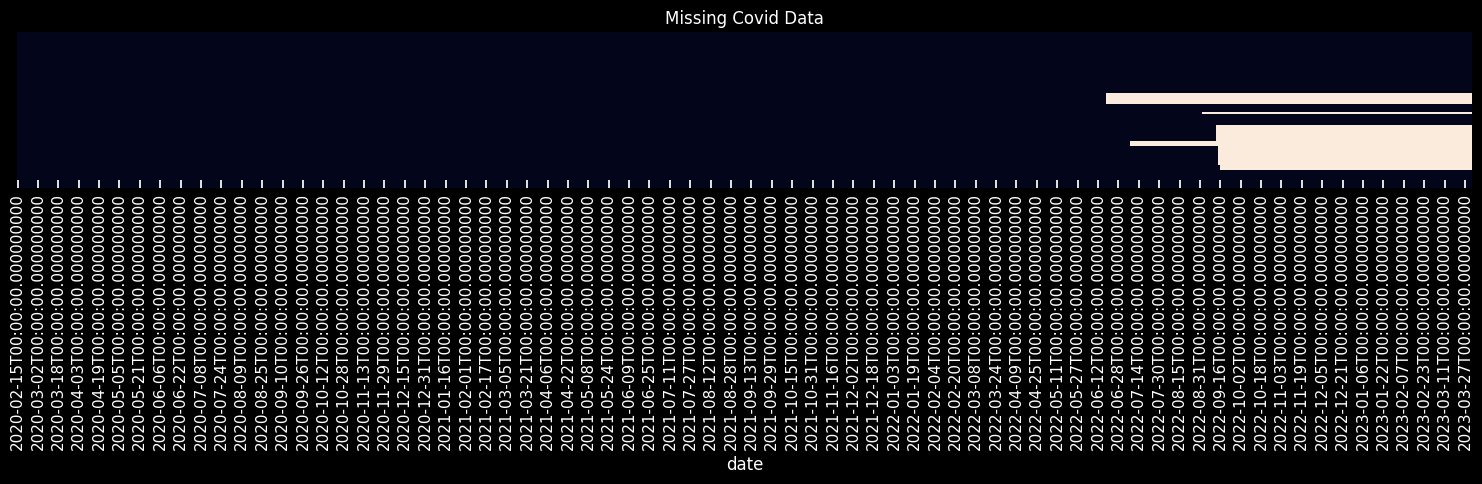

In [26]:
# master_df.index = pd.to_datetime(master_df.index).date
# import matplotlib.dates as mdates

# Your existing code
plt.figure(figsize=(15,5))
sns.heatmap(master_df.isna().T, yticklabels=[], cbar=False)

# Setting x-axis to show every 3 months and starting from 2020-02-15
ax = plt.gca()

plt.title("Missing Covid Data")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [27]:
cutoff_date = master_df.index.max() - pd.Timedelta(days=30)

train_df = master_df[master_df.index < cutoff_date].copy()
test_df = master_df[master_df.index >= cutoff_date].copy()


In [28]:
# Creating subplots vertically aligned
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=("Daily Confirmed", "Daily Hospitalizations", "Daily Fatalities"))

# Adding traces for the train dataset
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['new_confirmed'], name='Daily Confirmed (Train)', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['new_hospitalized_patients'], name='Daily Hospitalizations (Train)', line=dict(color='blue')), row=2, col=1)
fig.add_trace(go.Scatter(x=train_df.index, y=train_df['new_fatal'], name='Daily Fatalities (Train)', line=dict(color='blue')), row=3, col=1)

# Adding traces for the test dataset
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['new_confirmed'], name='Daily Confirmed (Test)', line=dict(color='red')), row=1, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['new_hospitalized_patients'], name='Daily Hospitalizations (Test)', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=test_df.index, y=test_df['new_fatal'], name='Daily Fatalities (Test)', line=dict(color='red')), row=3, col=1)

# Update the layout
fig.update_layout(height=800, width=1000, title='Daily Confirmed Cases, Hospitalizations, and Fatalities over Time')
fig.update_xaxes(title_text='Date', row=3, col=1)
fig.update_yaxes(title_text='Daily Confirmed Cases', row=1, col=1)
fig.update_yaxes(title_text='Daily Hospitalizations', row=2, col=1)
fig.update_yaxes(title_text='Daily Fatalities', row=3, col=1)

fig.show()


In [29]:
model = pm.auto_arima(train_df['new_confirmed'], 
                        start_p=10, max_p=30, 
                        start_q=1, max_q=10, # maximum p and q
                        # test='adf',       # use adftest to find optimal 'd'
                        d=None,           # let model determine 'd'
                        # m=1,              # frequency of series
                        # seasonal=False,   # No Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True, 
                        stationary=True,
                        n_jobs=-1,                        
                        )


C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(10,0,1)(0,0,0)[0] intercept   : AIC=27009.707, Time=2.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29313.639, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28245.420, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28822.183, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29772.834, Time=0.01 sec
 ARIMA(9,0,1)(0,0,0)[0] intercept   : AIC=27032.792, Time=2.56 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=27068.966, Time=1.14 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=27009.258, Time=3.31 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=27035.117, Time=1.33 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=26997.816, Time=2.83 sec
 ARIMA(12,0,0)(0,0,0)[0] intercept   : AIC=27011.090, Time=1.40 sec
 ARIMA(13,0,1)(0,0,0)[0] intercept   : AIC=26888.077, Time=4.47 sec
 ARIMA(13,0,0)(0,0,0)[0] intercept   : AIC=26947.721, Time=1.85 sec
 ARIMA(14,0,1)(0,0,0)[0] intercept   : AIC=26872.476, Time=5.51 sec
 ARIMA(14,

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:              SARIMAX(17, 0, 0)   Log Likelihood              -13412.007
Date:                Wed, 26 Jul 2023   AIC                          26862.014
Time:                        01:30:24   BIC                          26957.262
Sample:                    02-15-2020   HQIC                         26898.030
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5620.4286   2738.393      2.052      0.040     253.276     1.1e+04
ar.L1          0.0867      0.009      9.177      0.000       0.068       0.105
ar.L2          0.1223      0.016      7.869      0.000       0.092       0.153
ar.L3          0.2358      0.017     13.622      0.000       0.202       0.270
ar.L4          0.2038      0.017     11.908      0.000       0.170       0.237
ar.L5          0.1535      0.014     10.609      0.000       0.125       0.182
ar.L6          0.2890      0.011     25.425      0.000       0.267       0.311
ar.L7          0.5933      0.011     55.519      0.000       0.572       0.614
ar.L8          0.1416      0.010     13.856      0.000       0.122       0.162
ar.L9         -0.2363      0.013    -17.677      0.000      -0.262      -0.210
ar.L10        -0.2782      0.021    -13.303      0.000      -0.319      -0.237
ar.L11        -0.1825      0.021     -8.821      0.000      -0.223      -0.142
ar.L12        -0.1754      0.018     -9.770      0.000      -0.211      -0.140
ar.L13        -0.2539      0.014    -18.796      0.000      -0.280      -0.227
ar.L14         0.2075      0.011     19.095      0.000       0.186       0.229
ar.L15        -0.1277      0.011    -11.539      0.000      -0.149      -0.106
ar.L16         0.1079      0.016      6.607      0.000       0.076       0.140
ar.L17         0.0520      0.017      3.143      0.002       0.020       0.084
sigma2        1.8e+09      0.085   2.13e+10      0.000     1.8e+09     1.8e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38583.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+29. Standard errors may be unstable.
"""

In [31]:
model1 = pm.auto_arima(train_df['new_confirmed'])

model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -13655.524
Date:                Wed, 26 Jul 2023   AIC                          27327.048
Time:                        01:30:39   BIC                          27367.145
Sample:                    02-15-2020   HQIC                         27342.211
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1004      0.014      7.146      0.000       0.073       0.128
ar.L2         -0.6323      0.010    -60.845      0.000      -0.653      -0.612
ar.L3         -0.3585      0.015    -24.459      0.000      -0.387      -0.330
ar.L4         -0.3581      0.012    -30.946      0.000      -0.381      -0.335
ar.L5         -0.5335      0.016    -34.038      0.000      -0.564      -0.503
ma.L1         -0.9840      0.012    -79.380      0.000      -1.008      -0.960
ma.L2          0.7301      0.013     58.378      0.000       0.706       0.755
sigma2      3.012e+09   1.44e-12   2.09e+21      0.000    3.01e+09    3.01e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.36   Jarque-Bera (JB):             64786.46
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               2.74   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.75e+36. Standard errors may be unstable.
"""

In [32]:
model2 = pm.auto_arima(train_df['new_confirmed'], 
                        start_p=10, max_p=30, 
                        start_q=1, max_q=10, # maximum p and q
                        test='adf',       # use adftest to find optimal 'd'
                        d=None,           # let model determine 'd'
                        m=1,              # frequency of series
                        seasonal=False,   # No Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True, 
                        stationary=True,
                        n_jobs=-1,                        
                        )

model2.summary()

C:\Users\Samsickle\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(10,0,1)(0,0,0)[0] intercept   : AIC=27009.707, Time=2.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29313.639, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28245.420, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28822.183, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=29772.834, Time=0.01 sec
 ARIMA(9,0,1)(0,0,0)[0] intercept   : AIC=27032.792, Time=2.52 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=27068.966, Time=1.12 sec
 ARIMA(11,0,1)(0,0,0)[0] intercept   : AIC=27009.258, Time=3.33 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=27035.117, Time=1.33 sec
 ARIMA(12,0,1)(0,0,0)[0] intercept   : AIC=26997.816, Time=2.86 sec
 ARIMA(12,0,0)(0,0,0)[0] intercept   : AIC=27011.090, Time=1.41 sec
 ARIMA(13,0,1)(0,0,0)[0] intercept   : AIC=26888.077, Time=4.48 sec
 ARIMA(13,0,0)(0,0,0)[0] intercept   : AIC=26947.721, Time=1.87 sec
 ARIMA(14,0,1)(0,0,0)[0] intercept   : AIC=26872.476, Time=5.47 sec
 ARIMA(14,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:              SARIMAX(17, 0, 0)   Log Likelihood              -13412.007
Date:                Wed, 26 Jul 2023   AIC                          26862.014
Time:                        01:32:22   BIC                          26957.262
Sample:                    02-15-2020   HQIC                         26898.030
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5620.4286   2738.393      2.052      0.040     253.276     1.1e+04
ar.L1          0.0867      0.009      9.177      0.000       0.068       0.105
ar.L2          0.1223      0.016      7.869      0.000       0.092       0.153
ar.L3          0.2358      0.017     13.622      0.000       0.202       0.270
ar.L4          0.2038      0.017     11.908      0.000       0.170       0.237
ar.L5          0.1535      0.014     10.609      0.000       0.125       0.182
ar.L6          0.2890      0.011     25.425      0.000       0.267       0.311
ar.L7          0.5933      0.011     55.519      0.000       0.572       0.614
ar.L8          0.1416      0.010     13.856      0.000       0.122       0.162
ar.L9         -0.2363      0.013    -17.677      0.000      -0.262      -0.210
ar.L10        -0.2782      0.021    -13.303      0.000      -0.319      -0.237
ar.L11        -0.1825      0.021     -8.821      0.000      -0.223      -0.142
ar.L12        -0.1754      0.018     -9.770      0.000      -0.211      -0.140
ar.L13        -0.2539      0.014    -18.796      0.000      -0.280      -0.227
ar.L14         0.2075      0.011     19.095      0.000       0.186       0.229
ar.L15        -0.1277      0.011    -11.539      0.000      -0.149      -0.106
ar.L16         0.1079      0.016      6.607      0.000       0.076       0.140
ar.L17         0.0520      0.017      3.143      0.002       0.020       0.084
sigma2        1.8e+09      0.085   2.13e+10      0.000     1.8e+09     1.8e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38583.48
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.15e+29. Standard errors may be unstable.
"""

In [33]:
model3 = pm.auto_arima(train_df['new_confirmed'], 
                        start_p=10, max_p=30, 
                        start_q=1, max_q=10, # maximum p and q
                        # test='adf',       # use adftest to find optimal 'd'
                        d=None,           # let model determine 'd'
                        # m=1,              # frequency of series
                        # seasonal=False,   # No Seasonality
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=False, 
                        stationary=True,
                        n_jobs=-1,                        
                        )

model3.summary()


Best model:  ARIMA(2,0,3)(0,0,0)[1] intercept
Total fit time: 5.669 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1111
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -13893.687
Date:                Wed, 26 Jul 2023   AIC                          27801.373
Time:                        01:32:28   BIC                          27836.464
Sample:                    02-15-2020   HQIC                         27814.642
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3941.1917    736.749      5.349      0.000    2497.191    5385.192
ar.L1          1.4020      0.012    112.745      0.000       1.378       1.426
ar.L2         -0.4308      0.012    -35.142      0.000      -0.455      -0.407
ma.L1         -1.2457      0.013    -94.882      0.000      -1.271      -1.220
ma.L2          0.0604      0.018      3.447      0.001       0.026       0.095
ma.L3          0.4627      0.008     55.458      0.000       0.446       0.479
sigma2      3.355e+09      0.002   1.99e+12      0.000    3.36e+09    3.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.11   Jarque-Bera (JB):             15050.75
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               5.15   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+29. Standard errors may be unstable.
"""

In [34]:
dddddd

NameError: name 'dddddd' is not defined

In [ ]:
# estimators = [('scaler', None),
#             ('feature_selection', None),
#             ('dim_reducer', None),
#             ('model', ARIMA())]

# pipe = Pipeline(estimators) #, memory=cachedir

# param_grid = {
#     'model__p': list(range(16)),
#     'model__d': list(range(3)),
#     'model__q': list(range(16))
# }

# # 4. Split the dataset using TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)

# # 5. Set up and run the GridSearchCV
# gsearch = GridSearchCV(estimator=pipe, cv=tscv, param_grid=param_grid, verbose=1, n_jobs=-1)
# gsearch.fit(train_df.index.values.reshape(-1, 1), train_df['new_confirmed'])

# print(gsearch.best_params_)


# best_score, best_cfg = float("inf"), None

# GridSearchCV
# for train_index, validation_index in tscv.split(train_df['new_confirmed']):
#     train, test = train_df['new_confirmed'].iloc[train_index], train_df['new_confirmed'].iloc[validation_index]

#     try:
#         model = pm.auto_arima(train, start_p=1, start_q=1,
#                         test='adf',       # use adftest to find optimal 'd'
#                         max_p=15, max_q=3, # maximum p and q
#                         m=1,              # frequency of series
#                         d=None,           # let model determine 'd'
#                         seasonal=False,   # No Seasonality
#                         start_P=0, 
#                         D=0, 
#                         trace=True,
#                         error_action='ignore',  
#                         suppress_warnings=True, 
#                         stepwise=True, 
#                         stationary=True,
#                         n_jobs=-1)
#     except:
#         continue
#     predictions = model.predict(n_periods=len(test))
#     mse = mean_squared_error(test, predictions)
    
#     if mse < best_score:
#         best_score, best_cfg = mse, (model.order, model.seasonal_order)
#         best_model = model

# print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
# best_model.summary()

# gsearch = GridSearchCV(estimator=model, cv=tscv,
#                         param_grid=param_search)
# gsearch.fit(X, y)


In [ ]:
ssssssssss
tscv = TimeSeriesSplit(n_splits=5)

for train_index, validation_index in tscv.split(series['Confirmed']):


model = pm.auto_arima(y= test_df['new_confirmed'], start_p=1, start_q=1,
                    ['new_confirmed'], start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=20, max_q=5, # maximum p and q
                    m=1,              # frequency of series
                    d=None,           # let model determine 'd'
                    seasonal=False,   # No Seasonality
                    start_P=0, 
                    D=0, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

print(model.summary())


IndentationError: expected an indented block (4233500048.py, line 9)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np
X = np.array([[4, 5, 6, 1, 0, 2], [3.1, 3.5, 1.0, 2.1, 8.3, 1.1]]).T
y = np.array([1, 6, 7, 1, 2, 3])

model = ARIMA()
param_search = {'max_depth' : [3, 5]}

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(estimator=model, cv=tscv,
                        param_grid=param_search)
gsearch.fit(X, y)

TypeError: __init__() missing 1 required positional argument: 'endog'

In [ ]:
# Performing seasonal decomposition on 'new_confirmed' column
decomposition = tsa.seasonal_decompose(master_df['new_confirmed'], model='additive', period=12)

# Adding the decomposition data to the dataframe
master_df["Trend"] = decomposition.trend
master_df["Seasonal"] = decomposition.seasonal
master_df["Residual"] = decomposition.resid


In [ ]:

# Creating subplots for the trend, seasonal, and residual components
cols = ["Trend", "Seasonal", "Residual"]
fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(go.Scatter(x=master_df.index, y=master_df[col], name=col), row=i+1, col=1)

fig.update_layout(height=800, width=1200, title='Seasonal Decomposition of Daily Confirmed Cases')
fig.show()



#### Checking Stationarity
Before applying SARIMA, it's essential to ensure our time series is stationary.


In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    return dfoutput

check_stationarity(master_df['new_confirmed'])



Test Statistic                   -4.769730
p-value                           0.000062
#Lags Used                       21.000000
Number of Observations Used    1120.000000
dtype: float64


If the `p-value` is less than 0.05, the series is stationary. Otherwise, you might need to take differences or transformations to make it stationary.



#### ACF and PACF plots
To determine the order of the AR and MA terms, we can plot the autocorrelation and partial autocorrelation charts.


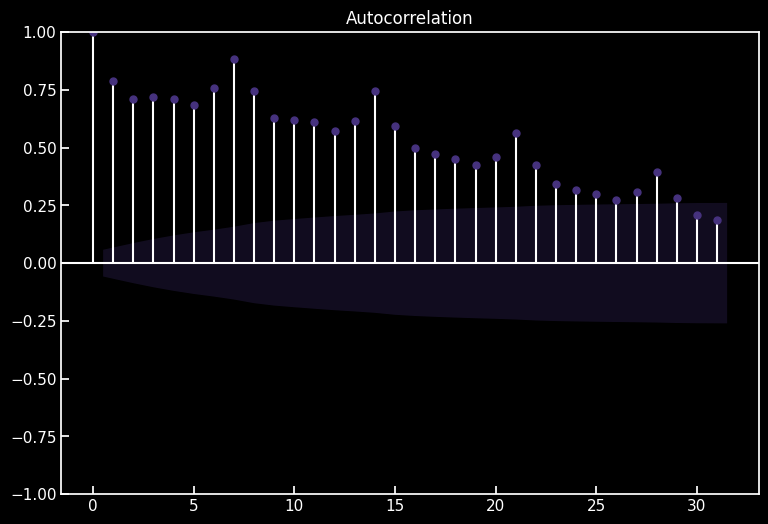

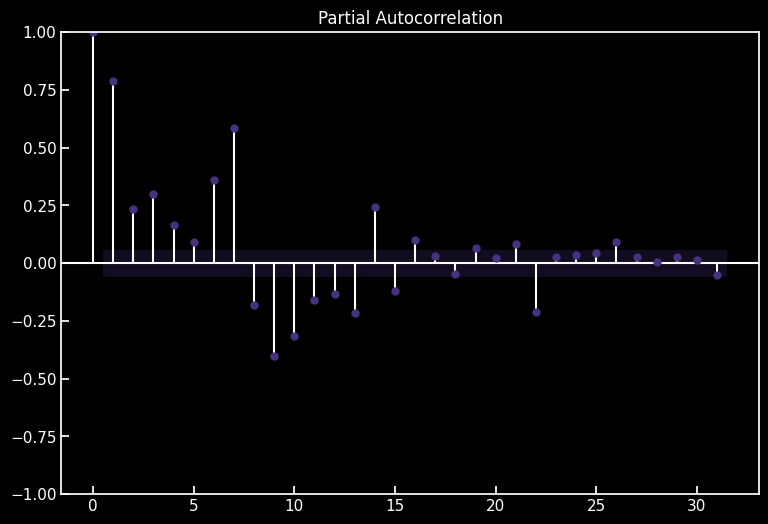

In [ ]:
plot_acf(master_df['new_confirmed'].dropna())
plot_pacf(master_df['new_confirmed'].dropna())
plt.show()




From the plots, we can determine the AR and MA terms by noting where the plot crosses the upper confidence interval for the first time.



#### SARIMA Model Training and Prediction

Once we have our terms, we can train our SARIMA model.


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(master_df['new_confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()
predictions = results.predict(start=start_date, end=end_date)



NameError: name 'p' is not defined


#### SARIMAX Model (if using exogenous variables)

If we want to use external predictors, SARIMAX is the way to go.


In [ ]:


exog_variables = master_df[['exog1', 'exog2']]
model = SARIMAX(master_df['new_confirmed'], exog=exog_variables, order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()
predictions = results.predict(start=start_date, end=end_date, exog=new_exog_data)




### Facebook Prophet Analysis

Facebook Prophet is designed for forecasting time series data. Let's see how we can use it.



#### Preparing Data for Prophet

Prophet requires the dataset to have two columns: `ds` and `y`, where `ds` is the timestamp and `y` is the value we want to predict.


In [ ]:


from fbprophet import Prophet

# Preparing data
prophet_df = master_df.reset_index()[['date', 'new_confirmed']]
prophet_df.columns = ['ds', 'y']

# Create and fit model
model = Prophet()
model.fit(prophet_df)

# Predictions
future = model.make_future_dataframe(periods=number_of_days_to_predict)
forecast = model.predict(future)
model.plot(forecast)




### Recurrent Neural Networks (RNNs)

RNNs are suitable for time series prediction due to their ability to recognize patterns in sequences of data.



#### Data Preprocessing for RNNs


In [ ]:


from sklearn.preprocessing import MinMaxScaler

data = master_df['new_confirmed'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for training
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])




#### Building and Training the RNN


In [ ]:


from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)




#### Predictions and Evaluation


In [ ]:


scaled_predictions = model.predict(X_test)
predictions = scaler.inverse_transform(scaled_predictions)




---

This outline gives a clear walkthrough of the different steps involved in each method. Depending on the specific details of your dataset and the problem at hand, you might need to adjust and fine-tune some of these steps.